In [1]:
import corner
import matplotlib.pyplot as plt
import numpy as np
import json
import emcee
import lmfit

In [2]:
with open('flux for2.txt') as fr:
	fl1 = json.load(fr)
with open('flux for8.txt') as fr:
	fl2 = json.load(fr)
with open('time.txt') as fr:
	time = json.load(fr)
with open('position of core for2.txt') as fr:
	position1 = json.load(fr)
with open('position of core for8.txt') as fr:
	position2 = json.load(fr)


crsh = np.array(position1) - np.array(position2)

inaccuracy_crshf=crsh*0.1

fl1=np.array(fl1)
fl2=np.array(fl2)


In [3]:
a_true=0
b1_true=1
b2_true=1
k_true=0.28
f_true = 1

<ErrorbarContainer object of 3 artists>

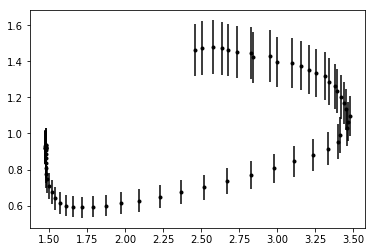

In [4]:
plt.errorbar(fl1, crsh, yerr=inaccuracy_crshf, fmt=".k", capsize=0)

<ErrorbarContainer object of 3 artists>

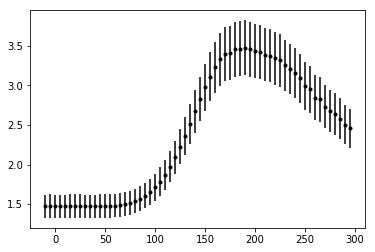

In [5]:
plt.errorbar(time, fl1, yerr=fl1*0.1, fmt=".k", capsize=0)

<ErrorbarContainer object of 3 artists>

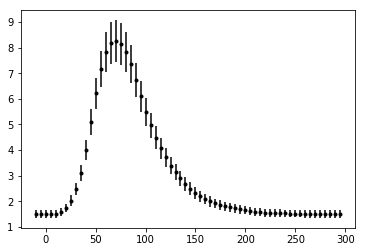

In [6]:
plt.errorbar(time, fl2, yerr=fl2*0.1, fmt=".k", capsize=0)

In [7]:
def log_likelihood(theta, fl1, fl2, crsh, inaccuracy_crshf):
    a,b1,b2,k= theta
    model = a + b1*fl1**k + b2*fl2**k
    #sigma2 = inaccuracy_crshf**2+ model ** 2 * np.exp(2 * log_f)
    sigma2 = inaccuracy_crshf**2
    return -0.5 * np.sum((crsh - model) ** 2 / sigma2 + np.log(sigma2))

In [8]:
from scipy.optimize import minimize
nll = lambda *args: -log_likelihood(*args)
#initial = np.array([a_true, b1_true, b2_true, k_true, np.log(f_true)]) + 0.1 * np.random.randn(5)
initial = np.array([a_true, b1_true, b2_true, k_true]) + 0.1 * np.random.randn(4)
soln = minimize(nll, initial, args=(fl1, fl2, crsh, inaccuracy_crshf))
#a_ml, b1_ml, b2_ml, k_ml, log_f_ml = soln.x
a_ml, b1_ml, b2_ml, k_ml = soln.x

In [9]:
print("Maximum likelihood estimates:")
print("a = {0:.3f}".format(a_ml))
print("b1 = {0:.3f}".format(b1_ml))
print("b2 = {0:.3f}".format(b2_ml))
print("k = {0:.3f}".format(k_ml))
#print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
a = 0.726
b1 = -0.341
b2 = 1.850
k = -3.079


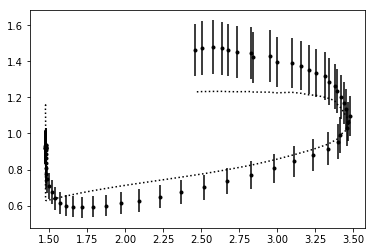

In [10]:
plt.errorbar(fl1, crsh, yerr=inaccuracy_crshf, fmt=".k", capsize=0)
#plt.plot(fl1, a_true + b1_true*fl1**k_true + b2_true*fl2**k_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(fl1, a_ml + b1_ml*fl1**k_ml + b2_ml*fl2**k_ml, ":k", label="ML")

In [11]:
def log_prior(theta):
    a,b1,b2,k = theta
    if -1.0 < a < 1. and -10. < b1 < 10.0 and -10. < b2 < 10.0 and 0.23 < k < 0.3:
        return 0.0
    return -np.inf

In [12]:
def log_probability(theta,fl1, fl2, crsh, inaccuracy_crshf):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, fl1, fl2, crsh, inaccuracy_crshf)

In [13]:
soln.x.shape

(4,)

In [14]:
pos = soln.x + 1e-4 * np.random.randn(32, 4)
#pos = soln.x
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(fl1, fl2, crsh, inaccuracy_crshf))
sampler.run_mcmc(pos, 5000, progress=True);

  0%|          | 0/5000 [00:00<?, ?it/s]/home/rustam/anaconda3/lib/python3.7/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in double_scalars
  lnpdiff = f + nlp - state.log_prob[j]
100%|██████████| 5000/5000 [00:08<00:00, 569.21it/s]


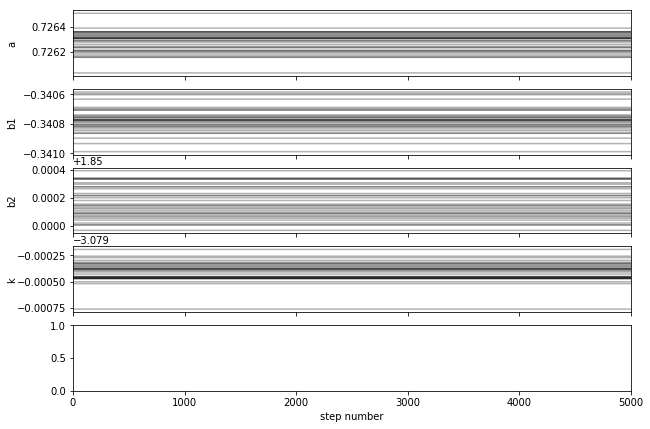

In [15]:
fig, axes = plt.subplots(5, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
labels = ["a", "b1","b2","k"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

In [16]:
tau = sampler.get_autocorr_time()
print(tau)

[nan nan nan nan]


/home/rustam/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:36: RuntimeWarning: invalid value encountered in true_divide
  acf /= acf[0]
/home/rustam/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:41: RuntimeWarning: invalid value encountered in less
  m = np.arange(len(taus)) < c * taus
/home/rustam/anaconda3/lib/python3.7/site-packages/emcee/autocorr.py:99: RuntimeWarning: invalid value encountered in greater
  flag = tol * tau_est > n_t


In [17]:
f_true = 0.1
k = 0.28
a = 0.4
def log_likelihood(theta, fl1, fl2, crsh, inaccuracy_crshf):
    b1,b2= theta
    model = a + b1*fl1**k + b2*fl2**k
    sigma2 = inaccuracy_crshf**2
    return -0.5 * np.sum((crsh - model) ** 2 / sigma2)

In [18]:
from scipy.optimize import minimize
nll = lambda *args: -log_likelihood(*args)
initial = np.array([ b1_true, b2_true]) + 0.1 * np.random.randn(2)
soln = minimize(nll, initial, args=(fl1, fl2, crsh, inaccuracy_crshf))
b1_ml, b2_ml = soln.x

In [19]:
print("Maximum likelihood estimates:")
#print("a = {0:.3f}".format(a_ml))
print("b1 = {0:.3f}".format(b1_ml))
print("b2 = {0:.3f}".format(b2_ml))

#print("f = {0:.3f}".format(np.exp(log_f_ml)))

Maximum likelihood estimates:
b1 = 0.853
b2 = -0.430


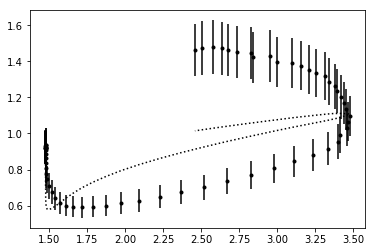

In [20]:
plt.errorbar(fl1, crsh, yerr=inaccuracy_crshf, fmt=".k", capsize=0)
#plt.plot(fl1, a_true + b1_true*fl1**k_true + b2_true*fl2**k_true, "k", alpha=0.3, lw=3, label="truth")
plt.plot(fl1, a + b1_ml*fl1**k + b2_ml*fl2**k, ":k", label="ML")